주제별 하이퍼파라미터
1. 각 문서별 주제 키워드가 몇개 나와야 관련 뉴스로 정의할 것인지, threshold
2. 주제별 word2vec size 결정하기, size
3. 주제별 doc2vec vectersize 결정하기, vecter_size
4. tfidf의 DBSCAN eps 결정하기, eps
5. doc2vec의 DBSCAN eps 결정하기, eps

In [7]:
"""
뉴스 자동분류 서비스
1. 토큰화
2. word2vec, bow
3. 새로운 query를 포함한 문서 추출
4. tf-idf, tf-idf 클러스터링, kmeans, dbscan, 시각화
5. doc2vec, doc2vec 클러스터링, kmeans, dbscan, 시각화
6. tf-idf+ count
- 멀캠 뉴사이트
"""
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import datetime
import re
from ckonlpy.tag import Twitter
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False


class MulCamNewSightTokenize:
    def __init__(self, add_dict=None, stopwords=None):
        self.reg_reporter = re.compile('[가-힣]+\s[가-힣]*기자')  # 기자
        self.reg_email = re.compile('[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$')  # 이메일
        self.reg_eng = re.compile('[a-z]+')  # 소문자 알파벳, 이메일 제거용, 대문자는 남겨둔다
        self.reg_chi = re.compile("[\u4e00-\u9fff]+")  # 한자
        self.reg_sc = re.compile("·|…|◆+|◇+|▶+|●+|▲+|“|”|‘|’|\"|\'|\(|\)")  # 특수문자
        self.reg_date = re.compile('\d+일|\d+월|\d+년|\d+시|\d+분|\(현지시간\)|\(현지시각\)|\d+')  # 날짜,시간,숫자
        self.add_dict = add_dict
        self.stopwords = stopwords

    def get_dataframe(self, data_name_with_route):
        """
        load news data
        """
        with open(data_name_with_route, 'rb') as file:
            data_list = []
            while True:
                try:
                    data = pickle.load(file)
                except EOFError:
                    break
                data_list.append(data)
        # construct lists for data frame
        title = []
        content = []
        date = []
        for news in data_list[0]['return_object']['documents']:
            title.append(news['title'])
            content.append(news['content'])
            date.append(news['published_at'][:10])  # 시간 조정이 필요하면 바꾸기
        # make lists as data frame
        news_data = pd.DataFrame([])
        news_data['date'] = date
        news_data['title'] = title
        news_data['content'] = content
        news_data['date_tmp'] = news_data['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').toordinal())
        return news_data

    def get_dataframe_from_list(self, data_names):
        """
        주소가 저장되어있는 리스트에서 data frame 만들기
        """
        news_data_list = []
        for data_name in data_names:
            news_data = self.get_dataframe(data_name)
            news_data_list.append(news_data)
        data = pd.DataFrame([])
        for news_data in news_data_list:
            data = data.append(news_data)
        data.reset_index(inplace=True)
        data.drop(['index'], axis=1, inplace=True)
        return data

    def preprocessing(self, doc):
        """
        정규표현식 전처리 함수
        """
        tmp = re.sub(self.reg_reporter, '', doc)
        tmp = re.sub(self.reg_email, '', tmp)
        tmp = re.sub(self.reg_eng, '', tmp)
        tmp = re.sub(self.reg_chi, '', tmp)
        tmp = re.sub(self.reg_sc, ' ', tmp)
        tmp = re.sub(self.reg_date, '', tmp)
        return tmp

    def make_content_re(self, data):
        data['content_re'] = data['content'].apply(self.preprocessing)
        return data

    def show_add_dict(self):
        print('add_dict: ', self.add_dict)

    def show_stopwords(self):
        print('stopwords: ', self.stopwords)

    def tokenize(self, data):
        print('add_dict:', self.add_dict)
        print('불용어: ', self.stopwords)
        twitter = Twitter()
        twitter.add_dictionary(self.add_dict, 'Noun')
        tokenized_doc = data['content_re'].apply(lambda x: twitter.nouns(x))
        tokenized_doc_without_stopwords = tokenized_doc.apply(
            lambda x: [item.lower() for item in x if item not in self.stopwords])
        data["tokenized_doc"] = tokenized_doc_without_stopwords
        return data


class GetSimilarWords(Word2Vec):
    def get_model(self, tokenized_doc, size=300, window=5, min_count=5, workers=4, sg=1):
        self.model = Word2Vec(sentences=tokenized_doc, size=size, window=window, min_count=min_count, workers=workers,
                              sg=sg)

    def get_similar_words(self, string):
        for word, score in self.model.wv.most_similar(string):
            print(word)


class GetStopWords:
    def get_bow(self, sentences):
        self.tmp_list = []
        for doc in sentences:
            self.tmp_list.extend(doc)
        self.word_count = pd.Series(self.tmp_list).value_counts()
        self.word_count_idx = list(self.word_count.index)

    def get_stop_words(self, number):
        stop_words_candi = self.word_count_idx[:number] + self.word_count_idx[-number:]
        for word in stop_words_candi:
            print(word)


class GetDocsFromQuery:
    def __init__(self, query):
        self.query = query

    def select_news(self, tokenized_doc):
        selected_news = []
        for idx in range(len(tokenized_doc)):
            if self.query in tokenized_doc.iloc[idx]:
                selected_news.append(idx)
        print("length of selected news: ", len(selected_news))
        print("length of original data: ", len(tokenized_doc))
        return tokenized_doc.iloc[selected_news]


class Vectorizer:
    def get_tfidf_vec(self, query_doc, max_feat=None):
        query_doc = query_doc.apply(lambda x: ' '.join(x))
        obj = TfidfVectorizer(max_features=max_feat)  # max_features for lda
        x = obj.fit_transform(query_doc).toarray()
        words = np.array(obj.get_feature_names())
        return x, words

    def get_doc2vec(self, query_doc,
                    dm=1, dbow_words=1, window=8, vector_size=50, alpha=0.025,
                    seed=42, min_count=5, min_alpha=0.025, workers=4, hs=0, negative=10,
                    n_epochs=50, model_name='d2v.model'):
        tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(query_doc)]
        model = Doc2Vec(
            dm=dm,  # PV-DBOW => 0 / default 1
            dbow_words=dbow_words,  # w2v simultaneous with DBOW d2v / default 0
            window=window,  # distance between the predicted word and context words
            vector_size=vector_size,  # vector size
            alpha=alpha,  # learning-rate
            seed=seed,
            min_count=min_count,  # ignore with freq lower
            min_alpha=min_alpha,  # min learning-rate
            workers=workers,  # multi cpu
            hs=hs,  # hierarchical softmax / default 0
            negative=negative,  # negative sampling / default 5
        )
        model.build_vocab(tagged_data)
        print("corpus_count: ", model.corpus_count)

        for epoch in range(n_epochs):
            if epoch % 10 == 0:
                print('epoch: ', epoch)
            model.train(tagged_data,
                        total_examples=model.corpus_count,
                        epochs=model.epochs)
            model.alpha -= 0.0002  # decrease the learning rate
            model.min_alpha = model.alpha  # fix the learning rate, no decay
        model.save(model_name)
        print("Model Saved")
        model_loaded = Doc2Vec.load(model_name)
        print("Load Model")
        x_doc2vec = []
        for i in range(len(query_doc)):
            x_doc2vec.append(model_loaded.docvecs[i])
        x_doc2vec = np.array(x_doc2vec)
        return x_doc2vec

    def load_doc2vec_model(self, query_doc, model_name):
        print("Load Model")
        model_loaded = Doc2Vec.load(model_name)
        x_doc2vec = []
        for i in range(len(query_doc)):
            x_doc2vec.append(model_loaded.docvecs[i])
        x_doc2vec = np.array(x_doc2vec)
        return x_doc2vec


class Get2DPlot:
    def __init__(self, x, reduction_method="PCA",
                 learning_rate=200, init='pca', random_state=10,
                 cluster_method="DBSCAN", eps=7, min_sample=2, n_clusters=3):
        self.reduction_method = reduction_method
        self.learning_rate = learning_rate
        self.init = init
        self.random_state = random_state
        self.cluster_method = cluster_method
        self.eps = eps
        self.min_sample = min_sample
        self.n_clusters = n_clusters
        self.x_scaled = StandardScaler().fit_transform(x)

    def get_2D_vec(self):
        if self.reduction_method == 'TSNE':
            t_sne = TSNE(n_components=2, learning_rate=self.learning_rate, init=self.init,
                         random_state=self.random_state)
            self.vec = t_sne.fit_transform(self.x_scaled)
        elif self.reduction_method == 'PCA':
            pca = PCA(n_components=2)
            self.vec = pca.fit_transform(self.x_scaled)
        return self.vec

    def get_cluster_labels(self):
        if self.cluster_method == 'kmeans':
            cluster = KMeans(n_clusters=self.n_clusters, random_state=self.random_state).fit(self.x_scaled)
            self.cluster_labels = cluster.labels_
        elif self.cluster_method == 'DBSCAN':
            self.cluster_labels = DBSCAN(eps=self.eps, min_samples=self.min_sample).fit_predict(self.x_scaled)
        vec_pd = np.c_[self.vec, self.cluster_labels]
        self.vec_pd = pd.DataFrame(vec_pd, columns=['x', 'y', 'labels'])
        print(self.cluster_labels)

    def plot2D(self):
        print(self.reduction_method, self.cluster_method)
        groups = self.vec_pd.groupby('labels')
        fig, ax = plt.subplots()
        for name, group in groups:
            ax.plot(group.x,
                    group.y,
                    marker='o',
                    linestyle='',
                    label=name)
        # ax.legend(fontsize=12, loc='upper left') # legend position

        plt.title('%s Plot of %s' % (self.reduction_method, self.cluster_method), fontsize=20)
        plt.xlabel('x', fontsize=14)
        plt.ylabel('y', fontsize=14)
        plt.show()
        
class AnalyzingNewsData:
    def get_n_data_per_cluster(self, cluster_labels):
        tmp = pd.DataFrame(pd.Series(cluster_labels).value_counts(), columns=['counts'])
        tmp.index.name = 'cluster'
        return tmp

    def print_news_per_cluster(self, data, clusters, content='title'):
        for n in clusters:
            print('=' * 100, n)
            for i in range(len(data)):
                try:
                    print(data[data['labels'] == n][content].iloc[i])
                    print('*' * 100)
                except:
                    break
            print('=' * 100, n)

In [8]:
add_dict = ['그리고',
            '미래에셋',
            '미래에셋대우',
           'ibk',]
stopwords = []
roots = ['data/미래에셋대우/rawdata_미래에셋대우.pickle',]

In [9]:
newsight = MulCamNewSightTokenize(add_dict, stopwords)

In [10]:
data = newsight.get_dataframe_from_list(roots)
display(data.head())
#data = data[:10].copy()

data = newsight.make_content_re(data)
display(data.head())
data = newsight.tokenize(data)
display(data.head())

newsight.show_add_dict()
newsight.show_stopwords()

,date,title,content,date_tmp
0,2019-04-19,"NH투자證 `선택과 집중` 통했다…펀드설정액, 증권사 1위에 올라",지난해 말 조직개편을 통해 펀드 판매에 승부수를 띄운 NH투자증권이 올해 들어 금융...,737168
1,2019-04-19,"2차전지 기업들, 속속 '코스닥 입성' 채비","코윈테크, 8월 코스닥 상장 추진 \n \n \n[ 이우상 기자 ] 2차전지 생산용...",737168
2,2019-04-19,증시 호조에 증권株 `훨훨`…2분기 실적도 `맑음`,올해 들어 증시가 호조를 보이면서 증권주들이 1분기 양호한 성적표를 받아들었다. 이...,737168
3,2019-04-19,"한화 LifePlus TDF 설정 1년, 4% 대 운용성과 달성",한화 라이프플러스 상장지수펀드(ETF)의 수익률이 설정 이후 양호한 수익률을 올리고...,737168
4,2019-04-19,"미래에셋벤처투자의 사회적기업1호펀드, 72.4% 수익 올리고 청산돼",미래에셋벤처투자는 지난 2011년 42억원으로 결성했던 사회적기업1호펀드가 72.4...,737168


,date,title,content,date_tmp,content_re
0,2019-04-19,"NH투자證 `선택과 집중` 통했다…펀드설정액, 증권사 1위에 올라",지난해 말 조직개편을 통해 펀드 판매에 승부수를 띄운 NH투자증권이 올해 들어 금융...,737168,지난해 말 조직개편을 통해 펀드 판매에 승부수를 띄운 NH투자증권이 올해 들어 금융...
1,2019-04-19,"2차전지 기업들, 속속 '코스닥 입성' 채비","코윈테크, 8월 코스닥 상장 추진 \n \n \n[ 이우상 기자 ] 2차전지 생산용...",737168,"코윈테크, 코스닥 상장 추진 \n \n \n[ ] 차전지 생산용 설비 제조 기업..."
2,2019-04-19,증시 호조에 증권株 `훨훨`…2분기 실적도 `맑음`,올해 들어 증시가 호조를 보이면서 증권주들이 1분기 양호한 성적표를 받아들었다. 이...,737168,올해 들어 증시가 호조를 보이면서 증권주들이 기 양호한 성적표를 받아들었다. 이에 ...
3,2019-04-19,"한화 LifePlus TDF 설정 1년, 4% 대 운용성과 달성",한화 라이프플러스 상장지수펀드(ETF)의 수익률이 설정 이후 양호한 수익률을 올리고...,737168,한화 라이프플러스 상장지수펀드 ETF 의 수익률이 설정 이후 양호한 수익률을 올리고...
4,2019-04-19,"미래에셋벤처투자의 사회적기업1호펀드, 72.4% 수익 올리고 청산돼",미래에셋벤처투자는 지난 2011년 42억원으로 결성했던 사회적기업1호펀드가 72.4...,737168,미래에셋벤처투자는 지난 억원으로 결성했던 사회적기업호펀드가 .%의 수익을 올린 뒤...


add_dict: ['그리고', '미래에셋', '미래에셋대우', 'ibk']
불용어:  []


c:\python\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


,date,title,content,date_tmp,content_re,tokenized_doc
0,2019-04-19,"NH투자證 `선택과 집중` 통했다…펀드설정액, 증권사 1위에 올라",지난해 말 조직개편을 통해 펀드 판매에 승부수를 띄운 NH투자증권이 올해 들어 금융...,737168,지난해 말 조직개편을 통해 펀드 판매에 승부수를 띄운 NH투자증권이 올해 들어 금융...,"[지난해, 말, 조직개편, 통해, 펀드, 판매, 승, 부수, 투자, 증권, 올해, ..."
1,2019-04-19,"2차전지 기업들, 속속 '코스닥 입성' 채비","코윈테크, 8월 코스닥 상장 추진 \n \n \n[ 이우상 기자 ] 2차전지 생산용...",737168,"코윈테크, 코스닥 상장 추진 \n \n \n[ ] 차전지 생산용 설비 제조 기업...","[코윈, 테크, 코스닥, 상장, 추진, 차, 전지, 생산, 용, 설비, 제조, 기업..."
2,2019-04-19,증시 호조에 증권株 `훨훨`…2분기 실적도 `맑음`,올해 들어 증시가 호조를 보이면서 증권주들이 1분기 양호한 성적표를 받아들었다. 이...,737168,올해 들어 증시가 호조를 보이면서 증권주들이 기 양호한 성적표를 받아들었다. 이에 ...,"[올해, 증시, 호조, 보이, 면서, 증권, 주, 기, 양호, 성적표, 아들, 었다..."
3,2019-04-19,"한화 LifePlus TDF 설정 1년, 4% 대 운용성과 달성",한화 라이프플러스 상장지수펀드(ETF)의 수익률이 설정 이후 양호한 수익률을 올리고...,737168,한화 라이프플러스 상장지수펀드 ETF 의 수익률이 설정 이후 양호한 수익률을 올리고...,"[한화, 라이프, 플러스, 상, 장지수, 펀드, 의, 수익률, 설정, 이후, 양호,..."
4,2019-04-19,"미래에셋벤처투자의 사회적기업1호펀드, 72.4% 수익 올리고 청산돼",미래에셋벤처투자는 지난 2011년 42억원으로 결성했던 사회적기업1호펀드가 72.4...,737168,미래에셋벤처투자는 지난 억원으로 결성했던 사회적기업호펀드가 .%의 수익을 올린 뒤...,"[미래에셋, 처, 투자, 지난, 억원, 결성, 사회, 적기, 업호, 펀드, 의, 수..."


add_dict:  ['그리고', '미래에셋', '미래에셋대우', 'ibk']
stopwords:  []


In [11]:
def count_topic(tokenized_doc, topic):
    counting = []
    for news in data.tokenized_doc:
        counting.append(news.count(topic))
    return counting

def plot_hist(counting):
    counting_pd = pd.Series(counting)
    bins = len(counting_pd.value_counts())
    counting_pd.hist(figsize=(16, 12), bins=bins*3)
    plt.xlabel("counting", fontsize=14)
    plt.show()

def get_proper_news(data, counting, threshold):
    select = np.array(counting) >= threshold
    print('number of total data:', len(data))
    print('number of proper data:', sum(select))
    return data[select].copy()

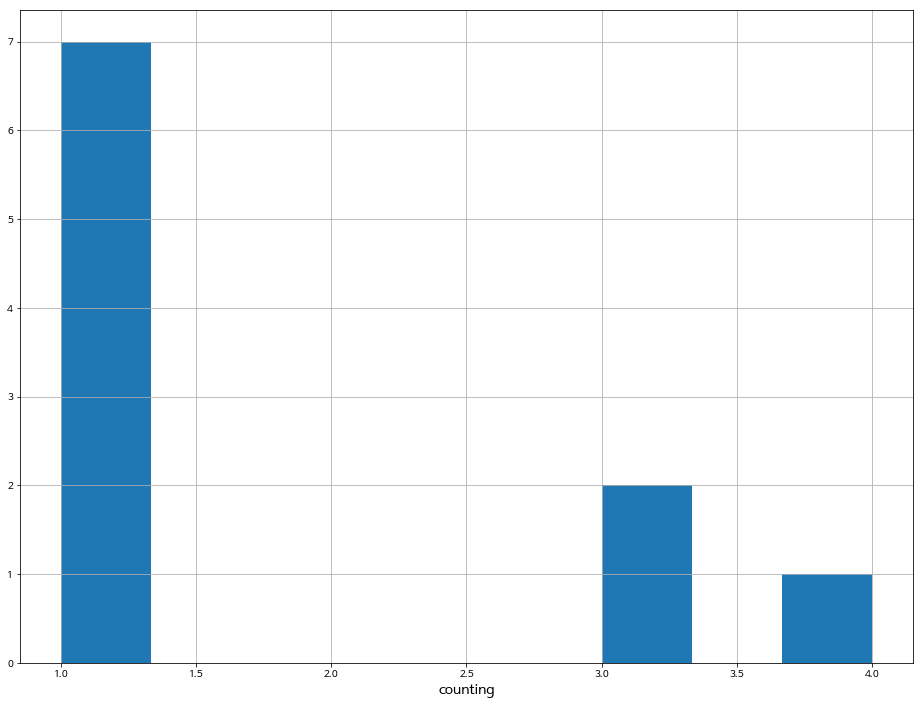

In [12]:
counting = count_topic(data.tokenized_doc, "미래에셋대우")
plot_hist(counting)

In [13]:
data = get_proper_news(data, counting, threshold=3)
#### 주제별로 다르게

number of total data: 10
number of proper data: 3


In [14]:
word2vec = GetSimilarWords()
word2vec.get_model(data.tokenized_doc, size=300)
word2vec.get_similar_words('미래에셋대우')

최근
를
수
대비
금융업
개인
업종
순
수준
패밀리


In [15]:
getstopwords = GetStopWords()
getstopwords.get_bow(data.tokenized_doc)
getstopwords.get_stop_words(10)

주가
대비
원
업종
거래
미래에셋대우
현재
주
로
기업
뒤
자리
내리락
성과
식
공공
눈
시장
정적
접근


In [16]:
getdoc = GetDocsFromQuery(query='미래에셋대우') 
query_docs = getdoc.select_news(data.tokenized_doc)

length of selected news:  3
length of original data:  3


In [17]:
vectorizer = Vectorizer()
Tfidfvec, words = vectorizer.get_tfidf_vec(query_docs)
doc2vec = vectorizer.get_doc2vec(query_docs, vector_size=50, n_epochs=50,
                                model_name='d2v.model')
## vector_size 조절하기!!!!!

corpus_count:  3
epoch:  0
epoch:  10
epoch:  20
epoch:  30
epoch:  40
Model Saved
Load Model


# 뉴스 데이터 분석하기

## tfidf

[0 0 0]
PCA DBSCAN


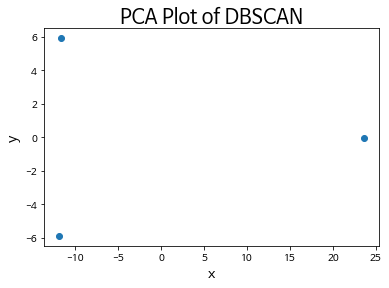

In [18]:
get_2d_plot = Get2DPlot(Tfidfvec, reduction_method="PCA",
                      cluster_method="DBSCAN", eps=70, min_sample=3, n_clusters=3)
## eps 크기 조정하기!!!!
Tfidf_2D_vec = get_2d_plot.get_2D_vec()
get_2d_plot.get_cluster_labels()
get_2d_plot.plot2D()

In [25]:
clusters = sorted(list(set(get_2d_plot.cluster_labels)))
new_data = data.loc[query_docs.index].copy()
new_data['labels'] = get_2d_plot.cluster_labels
analyzer = AnalyzingNewsData()
display(analyzer.get_n_data_per_cluster(get_2d_plot.cluster_labels))

,counts
cluster,
0,3


In [29]:
analyzer.print_news_per_cluster(new_data, analyzer.get_n_data_per_cluster(get_2d_plot.cluster_labels)[0:10].index, 'title')

==================================================================================================== 0
미래에셋대우-에트리홀딩스, 중소·벤처기업 성장지원 업무 협약
****************************************************************************************************
미래에셋대우, 에트리홀딩스와 `중소·벤처기업 성장 지원` MOU 체결
****************************************************************************************************
[ET투자뉴스]GS_거래비중 기관 39.68%, 외국인 39.95%
****************************************************************************************************
==================================================================================================== 0


### 이상치 탐색 추가하기

## doc2vec

[-1 -1 -1]
PCA DBSCAN


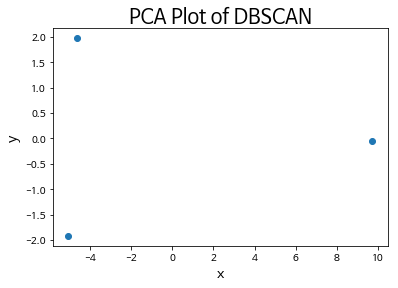

In [30]:
get_2d_plot = Get2DPlot(doc2vec, reduction_method="PCA",
                      cluster_method="DBSCAN", eps=6, min_sample=3, n_clusters=3)
## eps 조정하기!!!!
doc2vec_2D_vec = get_2d_plot.get_2D_vec()
get_2d_plot.get_cluster_labels()
get_2d_plot.plot2D()

In [31]:
clusters = sorted(list(set(get_2d_plot.cluster_labels)))
new_data = data.loc[query_docs.index].copy()
new_data['labels'] = get_2d_plot.cluster_labels
display(analyzer.get_n_data_per_cluster(get_2d_plot.cluster_labels))

,counts
cluster,
-1,3


In [34]:
analyzer.print_news_per_cluster(new_data, analyzer.get_n_data_per_cluster(get_2d_plot.cluster_labels)[0:10].index, 'title')

==================================================================================================== -1
미래에셋대우-에트리홀딩스, 중소·벤처기업 성장지원 업무 협약
****************************************************************************************************
미래에셋대우, 에트리홀딩스와 `중소·벤처기업 성장 지원` MOU 체결
****************************************************************************************************
[ET투자뉴스]GS_거래비중 기관 39.68%, 외국인 39.95%
****************************************************************************************************
==================================================================================================== -1


### 이상치 탐색 추가하기

# 시도해볼 방법들

1. 주제와 관련된 뉴스 찾기 아마 주제별로 다를듯? - 주제 키워드 등장 횟수
2. TFIDF와 Doc2vec 주제에 따라 둘 중 하나가  잘맞을 듯 - 주제 별로 시도하기
3. 정규표현식 전처리 할 때 공백으로 바꾸는게 낫지 않나? - 승현이형이랑 얘기하기
4. 키워드 추출은 제목이 더 나을 듯? - 승현이형이 어렵다함

# 해야할 일들
1. 클러스터 별 키워드 추출
2. 각 클러스터 별 핵심 뉴스 선택방식, BM25 score, TFIDF score
3. UI 논의하기